## Importing necessary library

In [194]:
import os
from google.cloud import language_v1
from google.cloud.language_v1 import enums
import matplotlib.pyplot as plt
import cv2
import argparse
import io
import json
from google.cloud import language
import numpy
import six
import PyPDF2

## Setting path to json key

In [113]:
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="/home/affine/GCP/downloaded_key.json"

- Sentiment analysis attempts to determine the overall attitude (positive or negative) and is represented by numerical score and magnitude values.


-  Sentiment analysis is performed through the analyzeSentiment method.

## 1) Analyzing Sentiment in a text string, text file and pdf file stored in local

we can access the service by calling the analyze_sentiment method of the LanguageServiceClient instance.


- Instantiates a LanguageServiceClient instance as the client.
- Reads the filename containing the text data into a variable.
- Instantiates a Document object with the contents of the file.
-  Calls the client's analyze_sentiment method.


In [185]:
def sample_analyze_sentiment(text_content):
    """
    Analyzing Sentiment in a String

    Args:
      text_content The text content to analyze
    """

    client = language_v1.LanguageServiceClient()
    

    # Available types: PLAIN_TEXT, HTML
    type_ = enums.Document.Type.PLAIN_TEXT

    # Optional. If not specified, the language is automatically detected.
    # For list of supported languages:
    # https://cloud.google.com/natural-language/docs/languages
    language = "en"
    document = {"content": text_content, "type": type_, "language": language}

    # Available values: NONE, UTF8, UTF16, UTF32
    encoding_type = enums.EncodingType.UTF8

    response = client.analyze_sentiment(document, encoding_type=encoding_type)
    print('response: \n', response)
    
    
    # parsing response
    
    # Get overall sentiment of the input document
    print(u"Document sentiment score: {}".format(response.document_sentiment.score))
    print(
        u"Document sentiment magnitude: {}".format(
            response.document_sentiment.magnitude
        )
    )
    # Get sentiment for all sentences in the document
    for sentence in response.sentences:
        print(u"Sentence text: {}".format(sentence.text.content))
        print(u"Sentence sentiment score: {}".format(sentence.sentiment.score))
        print(u"Sentence sentiment magnitude: {}".format(sentence.sentiment.magnitude))

    # Get the language of the text, which will be the same as
    # the language specified in the request or, if not specified,
    # the automatically-detected language.
    print(u"Language of the text: {}".format(response.language))


### a) Analyzing Sentiment in a text string passed by user

In [186]:
# calling above function

sample_analyze_sentiment('I am glad that you came here. I am so happy and joyful.We will enjoy alot now. But they are not happy without us')

response: 
 document_sentiment {
  magnitude: 2.5999999046325684
  score: 0.4000000059604645
}
language: "en"
sentences {
  text {
    content: "I am glad that you came here."
  }
  sentiment {
    magnitude: 0.8999999761581421
    score: 0.8999999761581421
  }
}
sentences {
  text {
    content: "I am so happy and joyful.We will enjoy alot now."
    begin_offset: 30
  }
  sentiment {
    magnitude: 0.8999999761581421
    score: 0.8999999761581421
  }
}
sentences {
  text {
    content: "But they are not happy without us"
    begin_offset: 79
  }
  sentiment {
    magnitude: 0.6000000238418579
    score: -0.6000000238418579
  }
}

Document sentiment score: 0.4000000059604645
Document sentiment magnitude: 2.5999999046325684
Sentence text: I am glad that you came here.
Sentence sentiment score: 0.8999999761581421
Sentence sentiment magnitude: 0.8999999761581421
Sentence text: I am so happy and joyful.We will enjoy alot now.
Sentence sentiment score: 0.8999999761581421
Sentence sentiment 

** Output **

The response gives:

- The sentiment score for whole document
- The sentiment magnitude for whole document
- Sentence text
- The sentiment score for each sentence
- The sentiment magnitude for each sentence


- score of the sentiment ranges between -1.0 (negative) and 1.0 (positive) and corresponds to the overall emotional leaning of the text.

- magnitude indicates the overall strength of emotion (both positive and negative) within the given text, between 0.0 and +inf


- In above example

A response value of 0.4 score indicates that string is positive in emotion, while the value of 2.59 indicates a relatively emotional document, given its small size.
first sentence of the string contains a very high positive score of 0.89.

### b) Analyzing Sentiment in a text file stored in local

First reading text file and then passing text content to analyze sentiment on it.

In [116]:
# reading text file
filename = r'/home/affine/GCP/NLP_Sentiment_Analysis/SA1.txt'
file=open(filename,'r')
text_content=file.read()

# calling function to analyze sentiment
sample_analyze_sentiment(text_content)

response: 
 document_sentiment {
  magnitude: 2.5999999046325684
  score: 0.20000000298023224
}
language: "en"
sentences {
  text {
    content: "This movie is good."
  }
  sentiment {
    magnitude: 0.800000011920929
    score: 0.800000011920929
  }
}
sentences {
  text {
    content: "I am very happy after watching this."
    begin_offset: 20
  }
  sentiment {
    magnitude: 0.8999999761581421
    score: 0.8999999761581421
  }
}
sentences {
  text {
    content: "It represent today\'s society condition."
    begin_offset: 57
  }
  sentiment {
  }
}
sentences {
  text {
    content: "But many people will still not follow the rules and spread negativity."
    begin_offset: 97
  }
  sentiment {
    magnitude: 0.800000011920929
    score: -0.800000011920929
  }
}

Document sentiment score: 0.20000000298023224
Document sentiment magnitude: 2.5999999046325684
Sentence text: This movie is good.
Sentence sentiment score: 0.800000011920929
Sentence sentiment magnitude: 0.800000011920929
Sente

** Output**

A response value of 0.2 score indicates that string is slightly positive in emotion, while the value of 2.59 indicates a relatively emotional document, given its small size.
Second sentence has very high sentiment score of 0.89 and third sentence has very high negative score of -0.8.

### c) Analyzing Sentiment in a pdf file stored in local

First extracting text from pdf file using cloud vision api and then analyzing sentiment on extracted text.

In [197]:
from google.cloud import vision_v1
from google.cloud.vision_v1 import enums as e2

def analyze_sentiments(file_path):
    client = vision_v1.ImageAnnotatorClient()

    # Supported mime_type: application/pdf, image/tiff, image/gif
    mime_type = "application/pdf"
    with io.open(file_path, "rb") as f:
        content = f.read()
    input_config = {"mime_type": mime_type, "content": content}
    features = [{"type": e2.Feature.Type.DOCUMENT_TEXT_DETECTION}]

    requests = [{"input_config": input_config, "features": features}]

    response = client.batch_annotate_files(requests)
    for image_response in response.responses[0].responses:
        print(u"Full text: {}".format(image_response.full_text_annotation.text))
        pdf_text=image_response.full_text_annotation.text
    
    # calling below function to analyze sentiment
    sample_analyze_sentiment(pdf_text)

In [198]:
analyze_sentiments('sample.pdf')

Full text: Wireless Networking is relatively cheaper than wired Networks since they require no cables between the computers as well as lower long term costs due to less maintenance since there is less equipment. The reduction of cables also reduces the trip hazard caused by cables running along the floor in most homes.Wireless Networking is also very mobile and versatile.Wireless networks can easily be set up and dissembled.
Since wireless networking is a relatively new and contingent form of networking, it is filled with it own hazards and problems such as unreliability and security.Wireless networks have limited bandwidth, hence they cannot support Video Teleconferencing(VTC).

response: 
 document_sentiment {
  magnitude: 2.0
  score: 0.20000000298023224
}
language: "en"
sentences {
  text {
    content: "Wireless Networking is relatively cheaper than wired Networks since they require no cables between the computers as well as lower long term costs due to less maintenance since ther

## 2) Analyzing Sentiment from Google Cloud Storage

In [118]:
def sample_analyze_sentiment_uri(gcs_content_uri):
    """
    Analyzing Sentiment in text file stored in Cloud Storage

    Args:
      gcs_content_uri Google Cloud Storage URI where the file content is located.
      e.g. gs://[Your Bucket]/[Path to File]
    """

    client = language_v1.LanguageServiceClient()

    # gcs_content_uri = 'gs://cloud-samples-data/language/sentiment-positive.txt'

    # Available types: PLAIN_TEXT, HTML
    type_ = enums.Document.Type.PLAIN_TEXT

    # Optional. If not specified, the language is automatically detected.
    # For list of supported languages:
    # https://cloud.google.com/natural-language/docs/languages
    language = "en"
    document = {"gcs_content_uri": gcs_content_uri, "type": type_, "language": language}

    # Available values: NONE, UTF8, UTF16, UTF32
    encoding_type = enums.EncodingType.UTF8

    response = client.analyze_sentiment(document, encoding_type=encoding_type)
    print('response: \n', response)
    

    # Get overall sentiment of the input document
    print(u"Document sentiment score: {}".format(response.document_sentiment.score))
    print(
        u"Document sentiment magnitude: {}".format(
            response.document_sentiment.magnitude
        )
    )
    # Get sentiment for all sentences in the document
    for sentence in response.sentences:
        print(u"Sentence text: {}".format(sentence.text.content))
        print(u"Sentence sentiment score: {}".format(sentence.sentiment.score))
        print(u"Sentence sentiment magnitude: {}".format(sentence.sentiment.magnitude))

    # Get the language of the text, which will be the same as
    # the language specified in the request or, if not specified,
    # the automatically-detected language.
    print(u"Language of the text: {}".format(response.language))


### a) Analyzing Sentiment from text file stored in Google Cloud Storage

In [119]:
sample_analyze_sentiment_uri("gs://bucket0406/SA1.txt")

response: 
 document_sentiment {
  magnitude: 2.5999999046325684
  score: 0.20000000298023224
}
language: "en"
sentences {
  text {
    content: "This movie is good."
  }
  sentiment {
    magnitude: 0.800000011920929
    score: 0.800000011920929
  }
}
sentences {
  text {
    content: "I am very happy after watching this."
    begin_offset: 20
  }
  sentiment {
    magnitude: 0.8999999761581421
    score: 0.8999999761581421
  }
}
sentences {
  text {
    content: "It represent today\'s society condition."
    begin_offset: 57
  }
  sentiment {
  }
}
sentences {
  text {
    content: "But many people will still not follow the rules and spread negativity."
    begin_offset: 97
  }
  sentiment {
    magnitude: 0.800000011920929
    score: -0.800000011920929
  }
}

Document sentiment score: 0.20000000298023224
Document sentiment magnitude: 2.5999999046325684
Sentence text: This movie is good.
Sentence sentiment score: 0.800000011920929
Sentence sentiment magnitude: 0.800000011920929
Sente

### b) Analyzing Sentiment from pdf file stored in Google Cloud Storage

For this first we extract text from pdf file using cloud vision api and then analyze sentiments from that text.

In [148]:
from google.cloud import vision_v1
from google.cloud.vision_v1 import enums as e1
def analyze_sentiment(storage_uri,):
    mime_type = "application/pdf"
    client = vision_v1.ImageAnnotatorClient()
    gcs_source = {"uri": storage_uri}
    input_config = {"gcs_source": gcs_source, "mime_type": mime_type}
    features = [{"type": e1.Feature.Type.DOCUMENT_TEXT_DETECTION}]
    requests = [{"input_config": input_config, "features": features}]
    response = client.batch_annotate_files(requests)
    for image_response in response.responses[0].responses:
        #print(u"Full text: {}".format(image_response.full_text_annotation.text))
        pdf_text=image_response.full_text_annotation.text
        
    # calling below function to analyze sentiment on extracted text    
    sample_analyze_sentiment(pdf_text)

In [149]:
analyze_sentiment("gs://bucket0406/sample1.pdf")

response: 
 document_sentiment {
  magnitude: 2.0
  score: 0.20000000298023224
}
language: "en"
sentences {
  text {
    content: "Customers can purchase items from the comfort of their own homes or work place."
  }
  sentiment {
    magnitude: 0.5
    score: 0.5
  }
}
sentences {
  text {
    content: "Shopping is made easier and convenient for the customer through internet."
    begin_offset: 80
  }
  sentiment {
    magnitude: 0.800000011920929
    score: 0.800000011920929
  }
}
sentences {
  text {
    content: "It is also easy to cancel the transactions.Long duration and lack of proper inventory management result in delays in shipment.Lack of touch-feel-try creates concerns over the quality of the product on offer.The rate of cyber crimes has been increasing and customers."
    begin_offset: 154
  }
  sentiment {
    magnitude: 0.6000000238418579
    score: -0.6000000238418579
  }
}

Document sentiment score: 0.20000000298023224
Document sentiment magnitude: 2.0
Sentence text: Cus

## 3) Extract sentiment of a text in a picture stored in local

For this first we use cloud vision api to extract text from image and then use NLP api to analyze sentiment on extracted text.

In [172]:
def detect_text(path):
    """Detects text in the file."""
    from google.cloud import vision
    import io
    client = vision.ImageAnnotatorClient()
    with io.open(path, 'rb') as image_file:
        content = image_file.read()
    image = vision.types.Image(content=content)
    response = client.text_detection(image=image)
    
    texts = response.text_annotations
    print(texts[0].description,end='')
    image_text=texts[0].description
    
    # calling below function to analyze sentiment on extracted text from image
    sample_analyze_sentiment(image_text)

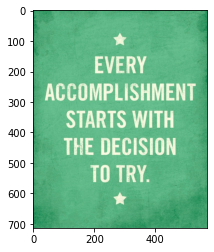

In [199]:
# image used 
img=plt.imread('/home/affine/GCP/NLP_Sentiment_Analysis/images6.jpg')
plt.imshow(img)

In [183]:
detect_text("/home/affine/GCP/NLP_Sentiment_Analysis/images6.jpg")

EVERY
ACCOMPLISHMENT
STARTS WITH
THE DECISION
TO TRY.
response: 
 document_sentiment {
  magnitude: 0.4000000059604645
  score: 0.4000000059604645
}
language: "en"
sentences {
  text {
    content: "EVERY\nACCOMPLISHMENT\nSTARTS WITH\nTHE DECISION\nTO TRY."
  }
  sentiment {
    magnitude: 0.4000000059604645
    score: 0.4000000059604645
  }
}

Document sentiment score: 0.4000000059604645
Document sentiment magnitude: 0.4000000059604645
Sentence text: EVERY
ACCOMPLISHMENT
STARTS WITH
THE DECISION
TO TRY.
Sentence sentiment score: 0.4000000059604645
Sentence sentiment magnitude: 0.4000000059604645
Language of the text: en


## 4) Extract sentiment of a text in a picture stored in cloud storage

For this first we use cloud vision api to extract text from image stored in google cloud and then use NLP api to analyze sentiment on extracted text.

In [180]:
# Detect text in a remote image
def detect_text_uri(uri):
    """Detects text in the file located in Google Cloud Storage or on the Web.
    """
    from google.cloud import vision
    client = vision.ImageAnnotatorClient()
    image = vision.types.Image()
    image.source.image_uri = uri
    response = client.text_detection(image=image)
    texts = response.text_annotations
    print(texts[0].description,end='')
    image_text=texts[0].description
    
    # calling below function to analyze sentiment on extracted text from image
    sample_analyze_sentiment(image_text)

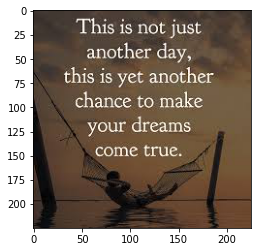

In [201]:
# Remote image used 
img=plt.imread('/home/affine/GCP/NLP_Sentiment_Analysis/images1.jpeg')
plt.imshow(img)

In [181]:
detect_text_uri("gs://bucket0406/images1.jpeg")

This is not just
another day,
this is yet another
chance to make
your dreams
come true.
response: 
 document_sentiment {
  magnitude: 0.8999999761581421
  score: 0.8999999761581421
}
language: "en"
sentences {
  text {
    content: "This is not just\nanother day,\nthis is yet another\nchance to make\nyour dreams\ncome true."
  }
  sentiment {
    magnitude: 0.8999999761581421
    score: 0.8999999761581421
  }
}

Document sentiment score: 0.8999999761581421
Document sentiment magnitude: 0.8999999761581421
Sentence text: This is not just
another day,
this is yet another
chance to make
your dreams
come true.
Sentence sentiment score: 0.8999999761581421
Sentence sentiment magnitude: 0.8999999761581421
Language of the text: en
